In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
from torch import optim
from sklearn.utils import class_weight
from torch.autograd import Variable
from tqdm import tqdm
from torch.utils.data import DataLoader

In [171]:
cyclone_events = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/cyclones_events.npz')
closeness_w = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/closeness_w.npy')
degree_w = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/degree_w.npy')
EVC_w = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/EVC_w.npy')
LCC_w = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/LCC_w.npy')
MSLP_preproc = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/input_data/MSLP_preproc.npy')

In [172]:
cyclone_events_2 = cyclone_events[cyclone_events.files[0]]
cyclone_events_4 = cyclone_events[cyclone_events.files[1]]
cyclone_events_6 = cyclone_events[cyclone_events.files[2]]
cyclone_events_8 = cyclone_events[cyclone_events.files[3]]
cyclone_events_10 = cyclone_events[cyclone_events.files[4]]
cyclone_events_12 = cyclone_events[cyclone_events.files[5]]

In [173]:
cyclone_events_2.shape

(36, 69, 113960)

In [174]:
MSLP_preproc = np.reshape(MSLP_preproc, (36, 69, 113960))

In [175]:
labels = np.zeros(113960)
for i in range(113960):
    if len(cyclone_events_2[:, :, i][cyclone_events_2[:, :, i] != False]) > 0:
        labels[i] = 1

In [176]:
'''
cyclone_occurances = []
no_cyclone = []
for i in range(113960):
    if len(cyclone_events_2[:, :, i][cyclone_events_2[:, :, i] != False]) > 0:
        cyclone_occurances.append(i)
    else:
        no_cyclone.append(i)
        
import random
random.shuffle(cyclone_occurances)
random.shuffle(no_cyclone)    

f1 = open("shuffle_cyclone.csv", "w")
f2 = open("shuffle_no_cyclone.csv", "w")
[f1.write(str(item) + ',') for item in cyclone_occurances]
[f2.write(str(item) + ',') for item in no_cyclone]
f1.close()
f2.close()
'''

'\ncyclone_occurances = []\nno_cyclone = []\nfor i in range(113960):\n    if len(cyclone_events_2[:, :, i][cyclone_events_2[:, :, i] != False]) > 0:\n        cyclone_occurances.append(i)\n    else:\n        no_cyclone.append(i)\n        \nimport random\nrandom.shuffle(cyclone_occurances)\nrandom.shuffle(no_cyclone)    \n\nf1 = open("shuffle_cyclone.csv", "w")\nf2 = open("shuffle_no_cyclone.csv", "w")\n[f1.write(str(item) + \',\') for item in cyclone_occurances]\n[f2.write(str(item) + \',\') for item in no_cyclone]\nf1.close()\nf2.close()\n'

In [177]:
data = MSLP_preproc.copy().astype(np.float32)

In [178]:
data = -np.log(1 - data + 1e-10)

In [179]:
data.dtype

dtype('float32')

In [180]:
cyclone_occurances = pd.read_csv("shuffle_cyclone.csv", header=None)
no_cyclone = pd.read_csv("shuffle_no_cyclone.csv", header=None)

np.nan_to_num(data, nan=0, copy=False)

cyclone_occurances = cyclone_occurances.values[0]
no_cyclone = no_cyclone.values[0]

cut_cyclone = int(0.8 * len(cyclone_occurances))
cut_no_cyclone = int(0.8 * len(no_cyclone))


train_id = cyclone_occurances[:cut_cyclone].astype(int)
train_id = np.append(train_id, no_cyclone[:cut_no_cyclone].astype(int))

test_id = cyclone_occurances[cut_cyclone:-1].astype(int) 
test_id = np.append(test_id, no_cyclone[cut_no_cyclone:-1].astype(int))

train_data = torch.tensor(data[:, :, train_id], dtype=torch.double)
test_data = torch.tensor(data[:, :, test_id], dtype=torch.double)

labels_train = torch.tensor(labels[train_id], dtype=torch.int)
labels_test = torch.tensor(labels[test_id], dtype=torch.int)

In [342]:
cyclone_events_12[:, :, 10584].sum()

0

In [ ]:
10584

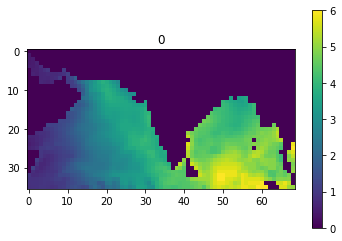

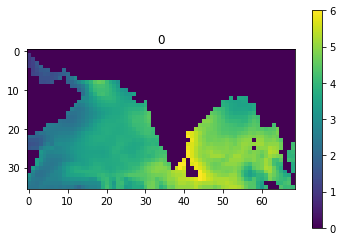

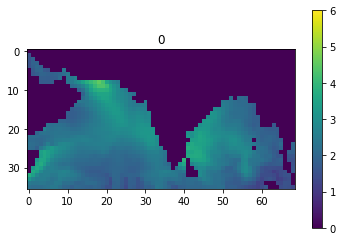

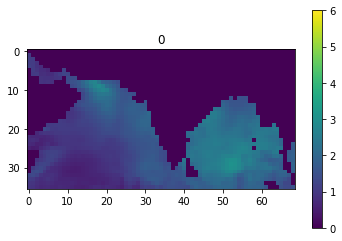

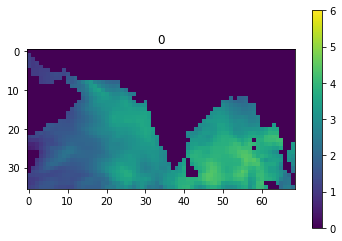

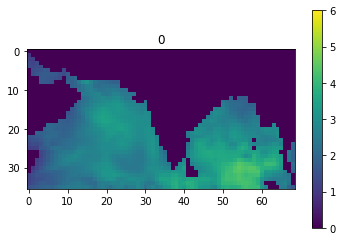

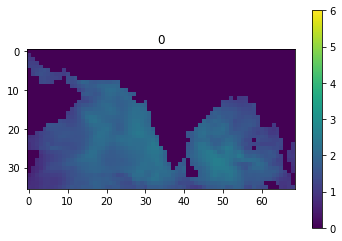

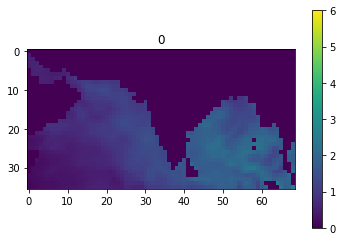

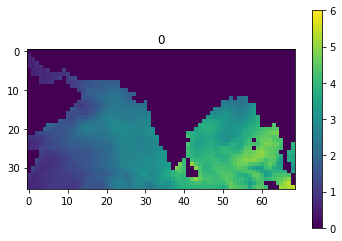

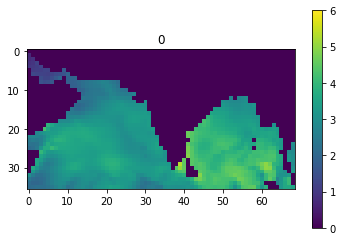

In [335]:
for t in range(-5, 5):
    plt.figure()
    plt.imshow(data[:, :, 10584 + t], vmin=0, vmax=6)
    plt.title((cyclone_events_2[:, :, 10584 + t]).sum())
    plt.colorbar()
    

In [327]:
no_cyclone[9650 - cut_cyclone]

10584.0

(array([16318.,  6477.,  6680.,  5000.,     0.,     0.,     0.,     0.,
            0.,  5305.]),
 array([ 0.       ,  2.3025851,  4.6051702,  6.907755 ,  9.2103405,
        11.512925 , 13.81551  , 16.118095 , 18.420681 , 20.723265 ,
        23.02585  ], dtype=float32),
 <BarContainer object of 10 artists>)

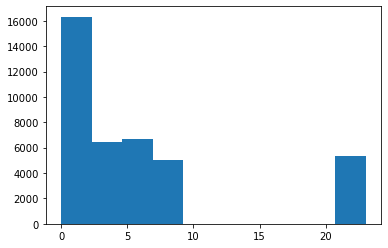

In [182]:
plt.hist(data[cyclone_events_2].flatten())

In [183]:
values = data[:, :, cyclone_occurances.astype(int)[:-1]]

In [323]:
len(cyclone_occurances.astype(int)[:-1])


9610

In [185]:
data[:, :, 87621]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.50984955, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.3839693 , 0.5106629 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.8356472 , 0.81227386, 0.7493869 , ..., 0.16946511, 0.08359924,
        0.        ],
       [0.86885005, 0.82333595, 0.73400986, ..., 0.15410998, 0.09716126,
        0.        ],
       [0.8653637 , 0.8188964 , 0.72388834, ..., 0.13590586, 0.08028687,
        0.03863983]], dtype=float32)

In [186]:
values[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

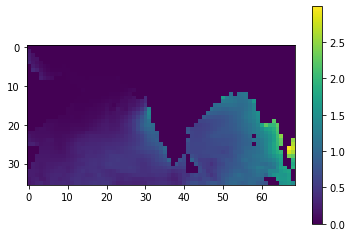

In [319]:
plt.imshow(data[:, :, 9651])
plt.colorbar()

In [188]:
import math
def conv2d_size_out(size, kernel_size=5, stride=2):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

def maxpool2d_size_out(size, kernel_size=2, stride=2):
    return math.floor((size - (kernel_size - 1) - 1) / stride + 1)

In [244]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=36,            
                kernel_size=5,          
                stride=2),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        new_w = maxpool2d_size_out(conv2d_size_out(36, 5, 2), 2, 2)
        new_h = maxpool2d_size_out(conv2d_size_out(69, 5, 2), 2, 2)
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=36,              
                out_channels=72,            
                kernel_size=5,          
                stride=2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        
        
        new_w = maxpool2d_size_out(conv2d_size_out(new_w, 5, 2), 2, 2)
        new_h = maxpool2d_size_out(conv2d_size_out(new_h, 5, 2), 2, 2)
        linear_input_size = new_w * new_h * 72
        # fully connected layer, output 2 classes
        self.lin = nn.Linear(linear_input_size, 2) 
        self.out = nn.Sigmoid()
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)      
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        x = self.lin(x)
        output = self.out(x)
        return output, x    
        

In [310]:
class MyLayer1(nn.Module):
    
    def __init__(self, w):
        super().__init__()   
        self.weight = w
        
    def forward(self, x):
        x = (x * self.weight - 1) * 50
        return x

class MyLayer2(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.sum(x) - 1

class SimpleNN(nn.Module):
    def __init__(self, w):
        super(SimpleNN, self).__init__()
        self.w = nn.Parameter(w, requires_grad=True)  
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = MyLayer1(self.w)
        self.sigmoid = nn.Sigmoid()
        self.layer2 = MyLayer2()

        #new_w = maxpool2d_size_out(size=36, kernel_size=2, stride=2)
        #new_h = maxpool2d_size_out(size=69, kernel_size=2, stride=2)
        #linear_input_size = new_w * new_h
        #self.layer2 = nn.Sequential(
        #    nn.Linear(linear_input_size, 1),
        #    nn.Sigmoid()
        #)
        
    
    def forward(self, x):
        plt.imshow(x[0, 0].detach().numpy())
        plt.colorbar()
        x = self.maxpool(x)
        #print(x)
        x = self.layer1(x)
        x = self.sigmoid(x)
        #print(x)
        x = self.layer2(x)
        #print(x)
        #x = self.sigmoid(x)
        #x = x.view(x.size(0), -1)
        #x = self.layer2(x)
        return x

In [322]:
labels_train[9650]

tensor(0, dtype=torch.int32)

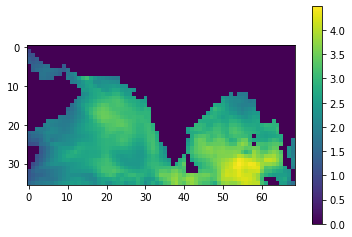

In [321]:
plt.imshow(train_data[:, :, 9650])
plt.colorbar()

In [312]:
w = torch.empty(size=(), dtype=torch.float)
nn.init.uniform_(w, a=0.5, b=0.5) # weight init

cnn = SimpleNN(w)

y = torch.tensor(list(labels_train))
class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
class_weights=torch.tensor(class_weights, dtype=torch.double)
print(class_weights)
loss_func = nn.BCEWithLogitsLoss(pos_weight=class_weights[1]/class_weights[0], reduction='mean') 
optimizer = optim.Adam(cnn.parameters(), lr = 0.0001)  

tensor([0.5460, 5.9292], dtype=torch.float64)


In [313]:
for name, param in cnn.named_parameters():
    print(name, param)

w Parameter containing:
tensor(0.5000, requires_grad=True)


100%|████████████████████████████████████████████████████████████████████████| 91168/91168 [00:00<00:00, 990055.87it/s]


tensor(0.3133, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.6180e-11, dtype=torch.float64)
w Parameter containing:
tensor(0.4997, dtype=torch.float64, requires_grad=True)


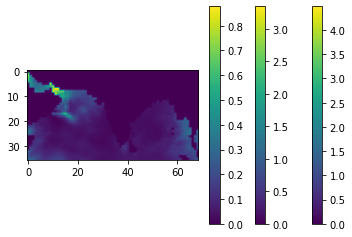

In [314]:
num_epochs = 1

def train(num_epochs, cnn, train_data, labels_train):  
    cnn.train()
    
    param_vals = []
    loss_vals = []
    output_vals = []
    
    cnn = cnn.double()
        
    # Train the model
    batch_size = 1
        
    for epoch in range(num_epochs):
        for i in tqdm(range(int(train_data.shape[2] / batch_size))):
            
            if (i != 9650):
                continue
            image = train_data[:, :, i]
            label = labels_train[i]   
            
            image = image.unsqueeze(0) 
            image = image.unsqueeze(0) 
            label = label.unsqueeze(0) 
            label = label.unsqueeze(0) 
            # gives batch data, normalize x when iterate train_loader
            
            b_x = image   # batch x
            b_y = label[0].to(torch.double)[0]  # batch y
            
            
            for name, param in cnn.named_parameters():
                param_vals.append(param.item())
                
            optimizer.zero_grad()
            
            output = cnn(b_x)
            output_vals.append(output.item())
            
            loss = loss_func(input=output, target=b_y)
            loss_vals.append(loss.item())
            
            # clear gradients for this training step   
            # backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer.step()  
        pass
        print(loss)
        print(list(cnn.parameters())[0].grad)
        for name, param in cnn.named_parameters():
            print(name, param)
    return param_vals, loss_vals, output_vals

pv, lv, ov = train(num_epochs, cnn, train_data, labels_train)

In [ ]:
b = [[0.9338, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [1.3183, 1.3183, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [1.4384, 1.5562, 1.6766, 0.0000, 1.3405, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [1.4302, 1.7220, 1.7667, 1.7004, 1.4847, 1.9410, 2.0717, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 1.6950, 1.7084, 1.5632, 0.0000, 1.9010, 2.4151, 3.1028,
           2.6548, 2.2680, 2.2728, 2.1953, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.2219, 2.5370,
           2.6759, 2.7193, 2.5432, 2.6759, 2.4598, 2.4372, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.9827, 2.4097,
           2.6830, 2.8797, 2.9996, 3.0707, 2.9151, 2.6830, 0.0000, 2.2823,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 2.3465, 2.1234, 1.9934, 1.8784, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.6257, 2.1909, 2.6830,
           2.9707, 3.2939, 3.2552, 3.2058, 3.1587, 2.9151, 2.7268, 2.6830,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           2.7494, 2.6618, 2.1997, 2.0992, 1.9898, 2.0115, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.7582, 2.1316, 2.7494,
           3.2426, 3.4502, 3.4199, 3.2679, 3.1138, 3.0295, 2.9333, 2.9333,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7648,
           2.9996, 2.7193, 2.4428, 2.2130, 2.3263, 2.4372, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 2.0115, 2.0188, 1.9043, 1.9175, 2.2265, 2.5557,
           3.1473, 3.4657, 3.4502, 3.3619, 3.3342, 3.1473, 2.9996, 2.9899,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.8043, 2.9333,
           2.8288, 2.6974, 2.8624, 2.7726, 2.5494, 2.6688, 0.0000, 2.8539,
           0.0000, 0.0000],
          [0.0000, 1.9010, 2.0449, 2.0755, 1.9513, 2.0794, 2.3829, 2.6140,
           2.8371, 3.1138, 3.2552, 3.3619, 3.3761, 3.1703, 2.9333, 3.0707,
           2.9333, 0.0000, 0.0000, 0.0000, 2.5126, 3.0095, 3.0194, 2.9061,
           3.0813, 2.9333, 3.1938, 3.0813, 2.8288, 2.7804, 2.9612, 2.9425,
           3.0499, 0.0000],
          [1.6559, 1.8105, 2.0912, 2.0992, 2.0717, 2.1953, 2.3829, 2.5309,
           2.7120, 2.9802, 3.1248, 3.0813, 3.1248, 3.1248, 2.8972, 3.0813,
           3.1138, 0.0000, 0.0000, 0.0000, 2.3935, 3.1138, 3.2679, 3.1587,
           3.2179, 3.0920, 3.2552, 3.1820, 3.0499, 2.8710, 2.6410, 2.7343,
           2.9333, 0.0000],
          [1.4100, 1.6207, 2.0262, 2.2728, 2.2447, 2.2823, 2.6140, 2.6688,
           2.6901, 2.8884, 2.9241, 3.0397, 3.1473, 2.9518, 2.7343, 3.0707,
           3.1473, 2.3465, 0.0000, 0.0000, 2.4947, 3.3071, 3.4975, 3.3905,
           3.4350, 3.4657, 3.1473, 3.7328, 3.5816, 3.1587, 3.1360, 3.2679,
           3.2939, 0.0000],
          [0.0000, 1.3021, 1.7302, 2.2219, 2.5309, 2.7648, 2.8624, 2.7418,
           2.7046, 2.8710, 2.9061, 2.7963, 2.7963, 2.6974, 2.5066, 2.9707,
           3.1587, 2.5812, 0.0000, 0.0000, 2.7963, 3.3206, 3.5642, 3.6734,
           3.6173, 3.6356, 3.6543, 3.5993, 3.3761, 3.7745, 3.3206, 3.6356,
           3.5137, 2.3619],
          [0.0000, 1.4160, 1.8816, 2.2919, 2.6073, 2.7648, 2.7268, 2.6479,
           2.8624, 3.0295, 3.0920, 2.7343, 2.4830, 2.5187, 2.4713, 2.8124,
           2.9425, 2.6901, 2.3568, 2.8624, 3.0499, 3.1587, 3.3761, 3.5303,
           3.6356, 3.8404, 4.1589, 4.4057, 4.1906, 3.9870, 4.0693, 4.0983,
           3.7328, 2.3114],
          [1.2128, 1.7638, 2.0411, 2.2775, 2.2728, 2.3723, 2.4830, 2.6342,
           2.8884, 3.1248, 3.1473, 3.1138, 2.7726, 2.5309, 2.5748, 2.8972,
           3.0499, 3.0603, 3.1820, 3.2058, 3.3905, 2.7418, 3.0194, 3.2939,
           3.6734, 4.0411, 4.3665, 4.4891, 4.4057, 4.3665, 3.8404, 3.7534,
           3.4975, 2.5684],
          [1.4446, 1.5891, 1.7057, 1.8978, 2.1316, 2.3568, 2.3829, 2.4485,
           2.6901, 3.1360, 3.1587, 3.2302, 3.0095, 2.9996, 2.8797, 2.7804,
           3.1360, 3.4815, 3.6173, 3.6928, 3.5471, 3.6356, 3.4975, 3.4815,
           3.5816, 4.1589, 4.1906, 4.3288, 4.1589, 4.1589, 3.5642, 3.0603,
           2.7268, 2.5248],
          [1.6407, 1.8532, 1.9582, 2.0912, 2.3619, 2.5066, 2.5370, 2.4541,
           2.3114, 2.5812, 2.6548, 2.7571, 2.8206, 2.7648, 2.9061, 2.5187,
           2.8455, 3.3480, 3.7126, 3.7960, 3.7534, 3.7960, 3.3905, 3.3071,
           3.5993, 3.9870, 4.0983, 4.2573, 4.2573, 4.0411, 3.1703, 0.0000,
           2.5877, 2.7120]]
plt.imshow(b)
plt.colorbar()

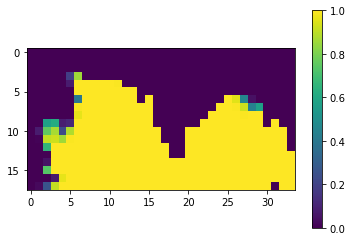

In [260]:
a = np.array([[2.6523e-12, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22],
          [3.9720e-08, 3.9720e-08, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22],
          [7.9913e-07, 1.5185e-05, 3.0791e-04, 1.9287e-22, 6.9088e-08,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22],
          [6.5106e-07, 9.5738e-04, 2.9211e-03, 5.5782e-04, 2.5443e-06,
           1.8633e-01, 8.5711e-01, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22],
          [1.9287e-22, 4.8822e-04, 6.8215e-04, 1.8075e-05, 1.9287e-22,
           7.7690e-02, 9.9997e-01, 1.0000e+00, 1.0000e+00, 9.9877e-01,
           9.9891e-01, 9.9247e-01, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22],
          [1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 9.9612e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 9.9999e-01, 9.9998e-01, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22],
          [1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 3.9360e-01, 9.9996e-01, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.9287e-22,
           9.9914e-01, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           9.9983e-01, 9.5623e-01, 4.5889e-01, 4.5668e-02, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22],
          [1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           8.6270e-05, 9.9161e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.0000e+00,
           1.0000e+00, 9.9325e-01, 9.2267e-01, 4.3677e-01, 5.7133e-01,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22],
          [1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           2.3612e-03, 9.6405e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 9.9998e-01, 9.9515e-01, 9.9971e-01, 9.9998e-01,
           1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22],
          [1.9287e-22, 1.9287e-22, 5.7133e-01, 6.1548e-01, 8.3760e-02,
           1.1282e-01, 9.9653e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.9287e-22, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.9287e-22, 1.9287e-22, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.9287e-22, 1.0000e+00, 1.9287e-22, 1.9287e-22],
          [1.9287e-22, 7.7690e-02, 7.5440e-01, 8.6859e-01, 2.2836e-01,
           8.7932e-01, 9.9993e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.9287e-22],
          [1.8366e-04, 8.6820e-03, 9.0727e-01, 9.2267e-01, 8.5711e-01,
           9.9247e-01, 9.9993e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.9287e-22, 1.9287e-22, 1.9287e-22,
           9.9995e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.9287e-22],
          [3.9289e-07, 7.6228e-05, 6.5812e-01, 9.9891e-01, 9.9780e-01,
           9.9914e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 9.9983e-01, 1.9287e-22, 1.9287e-22,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.9287e-22],
          [1.9287e-22, 2.6433e-08, 1.1758e-03, 9.9612e-01, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.9287e-22, 1.9287e-22,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9988e-01],
          [1.9287e-22, 4.5668e-07, 4.9285e-02, 9.9932e-01, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 9.9999e-01, 1.0000e+00, 9.9999e-01,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9987e-01, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9958e-01],
          [2.8385e-09, 2.7206e-03, 7.3654e-01, 9.9903e-01, 9.9891e-01,
           9.9991e-01, 9.9999e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
          [9.3292e-07, 3.4602e-05, 6.3779e-04, 7.2043e-02, 9.6405e-01,
           9.9987e-01, 9.9993e-01, 9.9999e-01, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
          [1.2552e-04, 2.4830e-02, 2.6015e-01, 9.0727e-01, 9.9988e-01,
           1.0000e+00, 1.0000e+00, 9.9999e-01, 9.9958e-01, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
           1.0000e+00, 1.9287e-22, 1.0000e+00, 1.0000e+00]])

plt.imshow(a)
plt.colorbar()

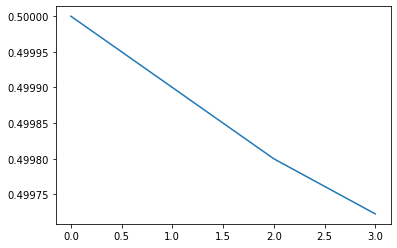

In [255]:
plt.plot(pv)

(0.0, 1.0)

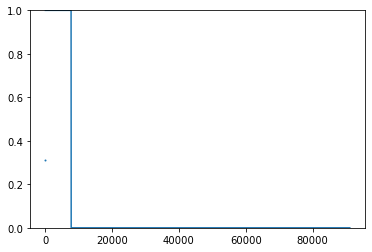

In [256]:
plt.scatter(np.arange(len(lv)), lv, s=1)
plt.plot(labels_train)
plt.ylim([0, 1])

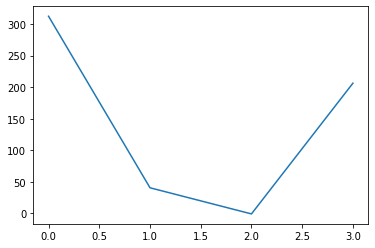

In [258]:
#plt.ylim([-3, 3])
plt.plot(ov[:100])

In [ ]:
for name, param in cnn.named_parameters():
    print(name, param)

In [20]:
def test(test_data, labels_test):
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        correct = 0
        total = 0
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for i in range(test_data.shape[2]):
            image = test_data[:, :, i]
            label = labels_test[i]
            image = image.unsqueeze(0) 
            image = image.unsqueeze(0) 
            
            test_output = cnn(image)
            pred_y = test_output[0, 1].item()
            
            # 0 - 1 when cyclone is present
            if (pred_y == label and label == 1):
                tp += 1
            # 1 - 0 when no cyclone is present
            elif (pred_y == label and label == 0):
                tn += 1
            # 0 - 1 when no cyclone is present
            elif (pred_y != label and label == 1):
                fn += 1
            # 1 - 0 when cyclone is present
            elif (pred_y != label and label == 0):
                fp += 1
            pass
        sensitivity = tp / (tp + fn)
        specificity = tn / (fp + tn)
        balanced_accuracy = (sensitivity + specificity) / 2
        print(f'Test Accuracy of the model on the {test_data.shape[2]} test images: %.2f' % balanced_accuracy)
    
    pass
test(test_data, labels_test)

Test Accuracy of the model on the 22792 test images: 0.50
